In [1]:
import math
import glob
import itertools
import random
from collections import Counter
from copy import deepcopy
# from memory_tempfile import MemoryTempfile

import dask.dataframe as dd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from gimmemotifs.cluster import cluster_motifs
from gimmemotifs.comparison import MotifComparer
from gimmemotifs.fasta import Fasta
from gimmemotifs.motif import Motif, read_motifs
from gimmemotifs.scanner import Scanner

from nopeak_utils.nopeak import NoPeakMotif
from tfomics import ReferenceGenome

%matplotlib inline

/Users/oalmelid/anaconda3/envs/nopeak_utils/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fontconfig warning: ignoring UTF-8: not a valid region tag


In [2]:
all_motifs = list(itertools.chain.from_iterable(NoPeakMotif.from_file(infile, strip_edges=False) for infile in glob.glob("data/*.motifs.*")))


In [3]:
print(len(glob.glob("data/*.motifs.*")))
print(len(all_motifs))

150
563


In [4]:
pd.DataFrame({ "motif" : [motif.id for motif in all_motifs], "information_content": [motif.information_content for motif in all_motifs]})

,motif,information_content
0,ENCFF775QDK_dedup.bam.motifs_0,17.037512
1,ENCFF775QDK_dedup.bam.motifs_1,16.811855
2,ENCFF775QDK_dedup.bam.motifs_2,12.885656
3,SRR3180007_dedup.bam.motifs_0,21.943952
4,SRR3180007_dedup.bam.motifs_1,18.874427
...,...,...
558,SRR299377_dedup.bam.motifs_0,18.972837
559,SRR299377_dedup.bam.motifs_1,13.638961
560,SRR604585_dedup.bam.motifs_0,14.283891
561,SRR604585_dedup.bam.motifs_1,21.701631


<AxesSubplot:xlabel='information_content', ylabel='Count'>

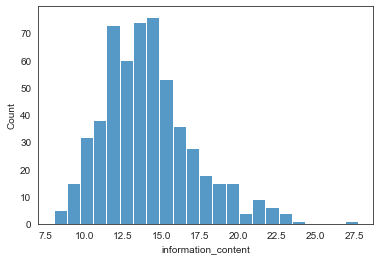

In [ ]:
sns.histplot(data=pd.DataFrame({"information_content": list(map(lambda x: x.information_content, all_motifs))}), x="information_content")

In [6]:
high_ic_motifs = [ motif for motif in all_motifs if motif.information_content > 15. ]

In [7]:
# print(len(high_ic_motifs))
mc = MotifComparer()
# best_matching_motifs = mc.get_closest_match(high_ic_motifs, dbmotifs=read_motifs("HOMER"), metric="seqcor", parallel=False)

In [57]:
def get_tf_from_name(name):
    identifier = name[0].split('/')[1]
    if not "-" in identifier:
        return identifier
    else:
        return identifier.split('-')[1]

In [ ]:
# closest_tf = [get_tf_from_name(motif) for motif in best_matching_motifs.values()]
# Counter([get_tf_from_name(motif) for motif in best_matching_motifs.values()])

In [ ]:
# [ motif.id for motif in high_ic_motifs ]

<AxesSubplot:ylabel='Density'>

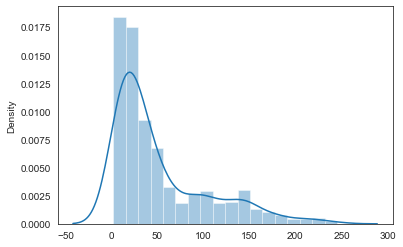

In [9]:
sns.distplot([ motif.kmer_count for motif in all_motifs ])

In [5]:
high_kmer_motifs = [motif for motif in all_motifs if int(motif.kmer_count) > 100]

In [11]:
print(len(high_kmer_motifs ))
mc = MotifComparer()
best_matching_motifs = mc.get_closest_match(high_kmer_motifs, dbmotifs=read_motifs("HOMER"), metric="seqcor", parallel=False)

100


In [12]:
len(best_matching_motifs)

100

In [13]:
closest_tf = [get_tf_from_name(motif) for motif in best_matching_motifs.values()]
Counter([get_tf_from_name(motif) for motif in best_matching_motifs.values()])

Counter({'CTCFL': 61,
         'Prdm15': 3,
         'NF1': 8,
         'BCL11A': 2,
         'CTCF': 14,
         'ZSCAN22.GFP': 1,
         'CellCycle': 3,
         'Atf7': 1,
         'Hoxa13.Flag': 1,
         'Zfp809': 1,
         'Pit1': 1,
         'EBF': 1,
         'Prep1': 1,
         'PRDM10.eGFP': 1,
         'ZNF768': 1})

In [ ]:
len({ motif.id for motif in high_kmer_motifs })

100

In [ ]:
affinities = [ [ mc.compare_motifs(motif_1, motif_2)[0] for motif_1 in high_kmer_motifs ] for motif_2 in high_kmer_motifs ]

<AxesSubplot:>

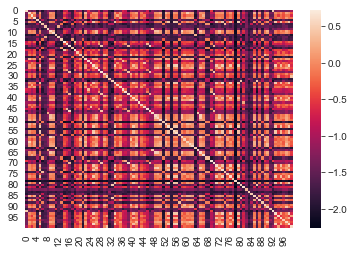

In [ ]:
sns.heatmap(affinities)

In [ ]:
{len(motif.pwm) for motif in high_kmer_motifs}

{24}

In [ ]:
scaled_pwms = StandardScaler().fit_transform([ list(itertools.chain(*motif.pwm)) for motif in high_kmer_motifs ])
pcs = pd.DataFrame(PCA(n_components=2).fit_transform(scaled_pwms), columns=["PC1", "PC2"])
pcs["motif"] = closest_tf
pcs["CTCF"] = (pcs["motif"] == "CTCF") | (pcs["motif"] == "CTCFL")

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

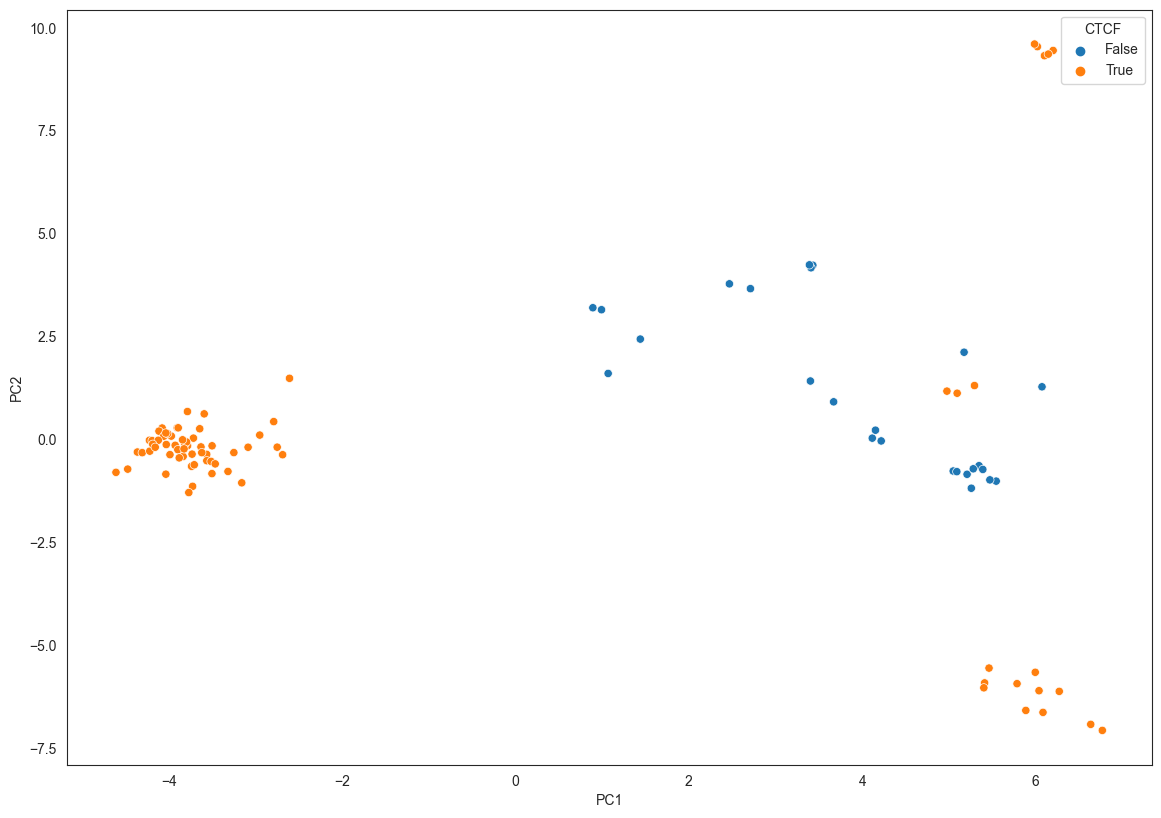

In [ ]:
f = plt.figure(figsize =(14,10), dpi=100)
sns.scatterplot(data=pcs, x="PC1", y="PC2", hue="CTCF")

In [ ]:
cl_1 = [high_kmer_motifs[i] for i in pcs[pcs.PC1 < 0].index]
cl_2 = [high_kmer_motifs[i] for i in pcs[pcs.PC2 < -3.8 ].index]
cl_3 = [high_kmer_motifs[i] for i in pcs[pcs.PC2 > 6 ].index]

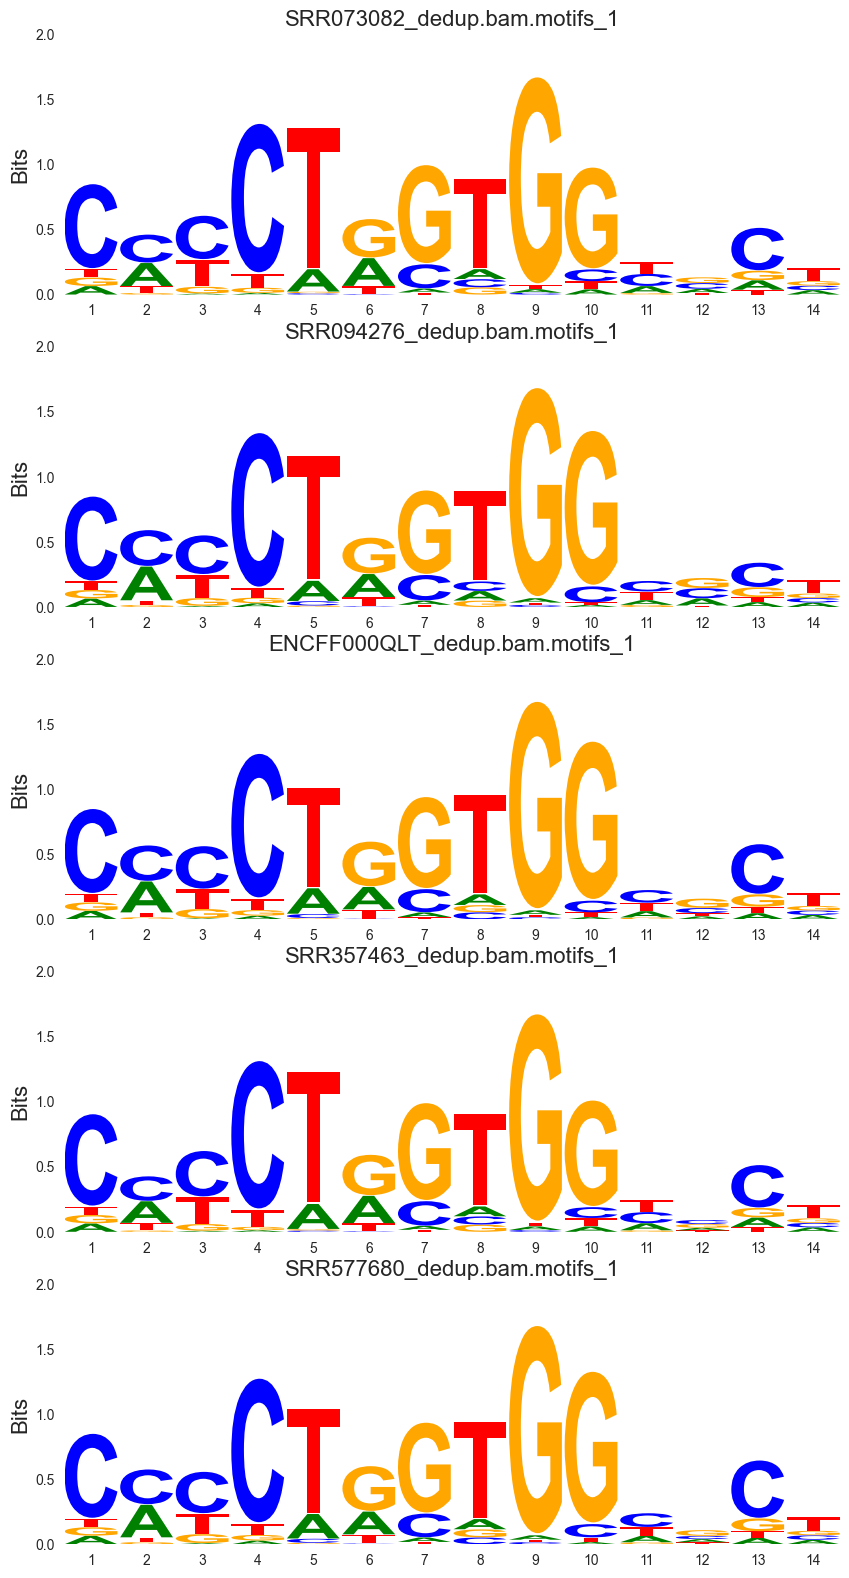

In [ ]:
plt.figure(figsize =(10,20), dpi=100)

for i, motif in enumerate(cl_3):
    ax = plt.subplot(len(cl_3), 1, i+1)
    motif.trim().plot_logo(ax=ax)



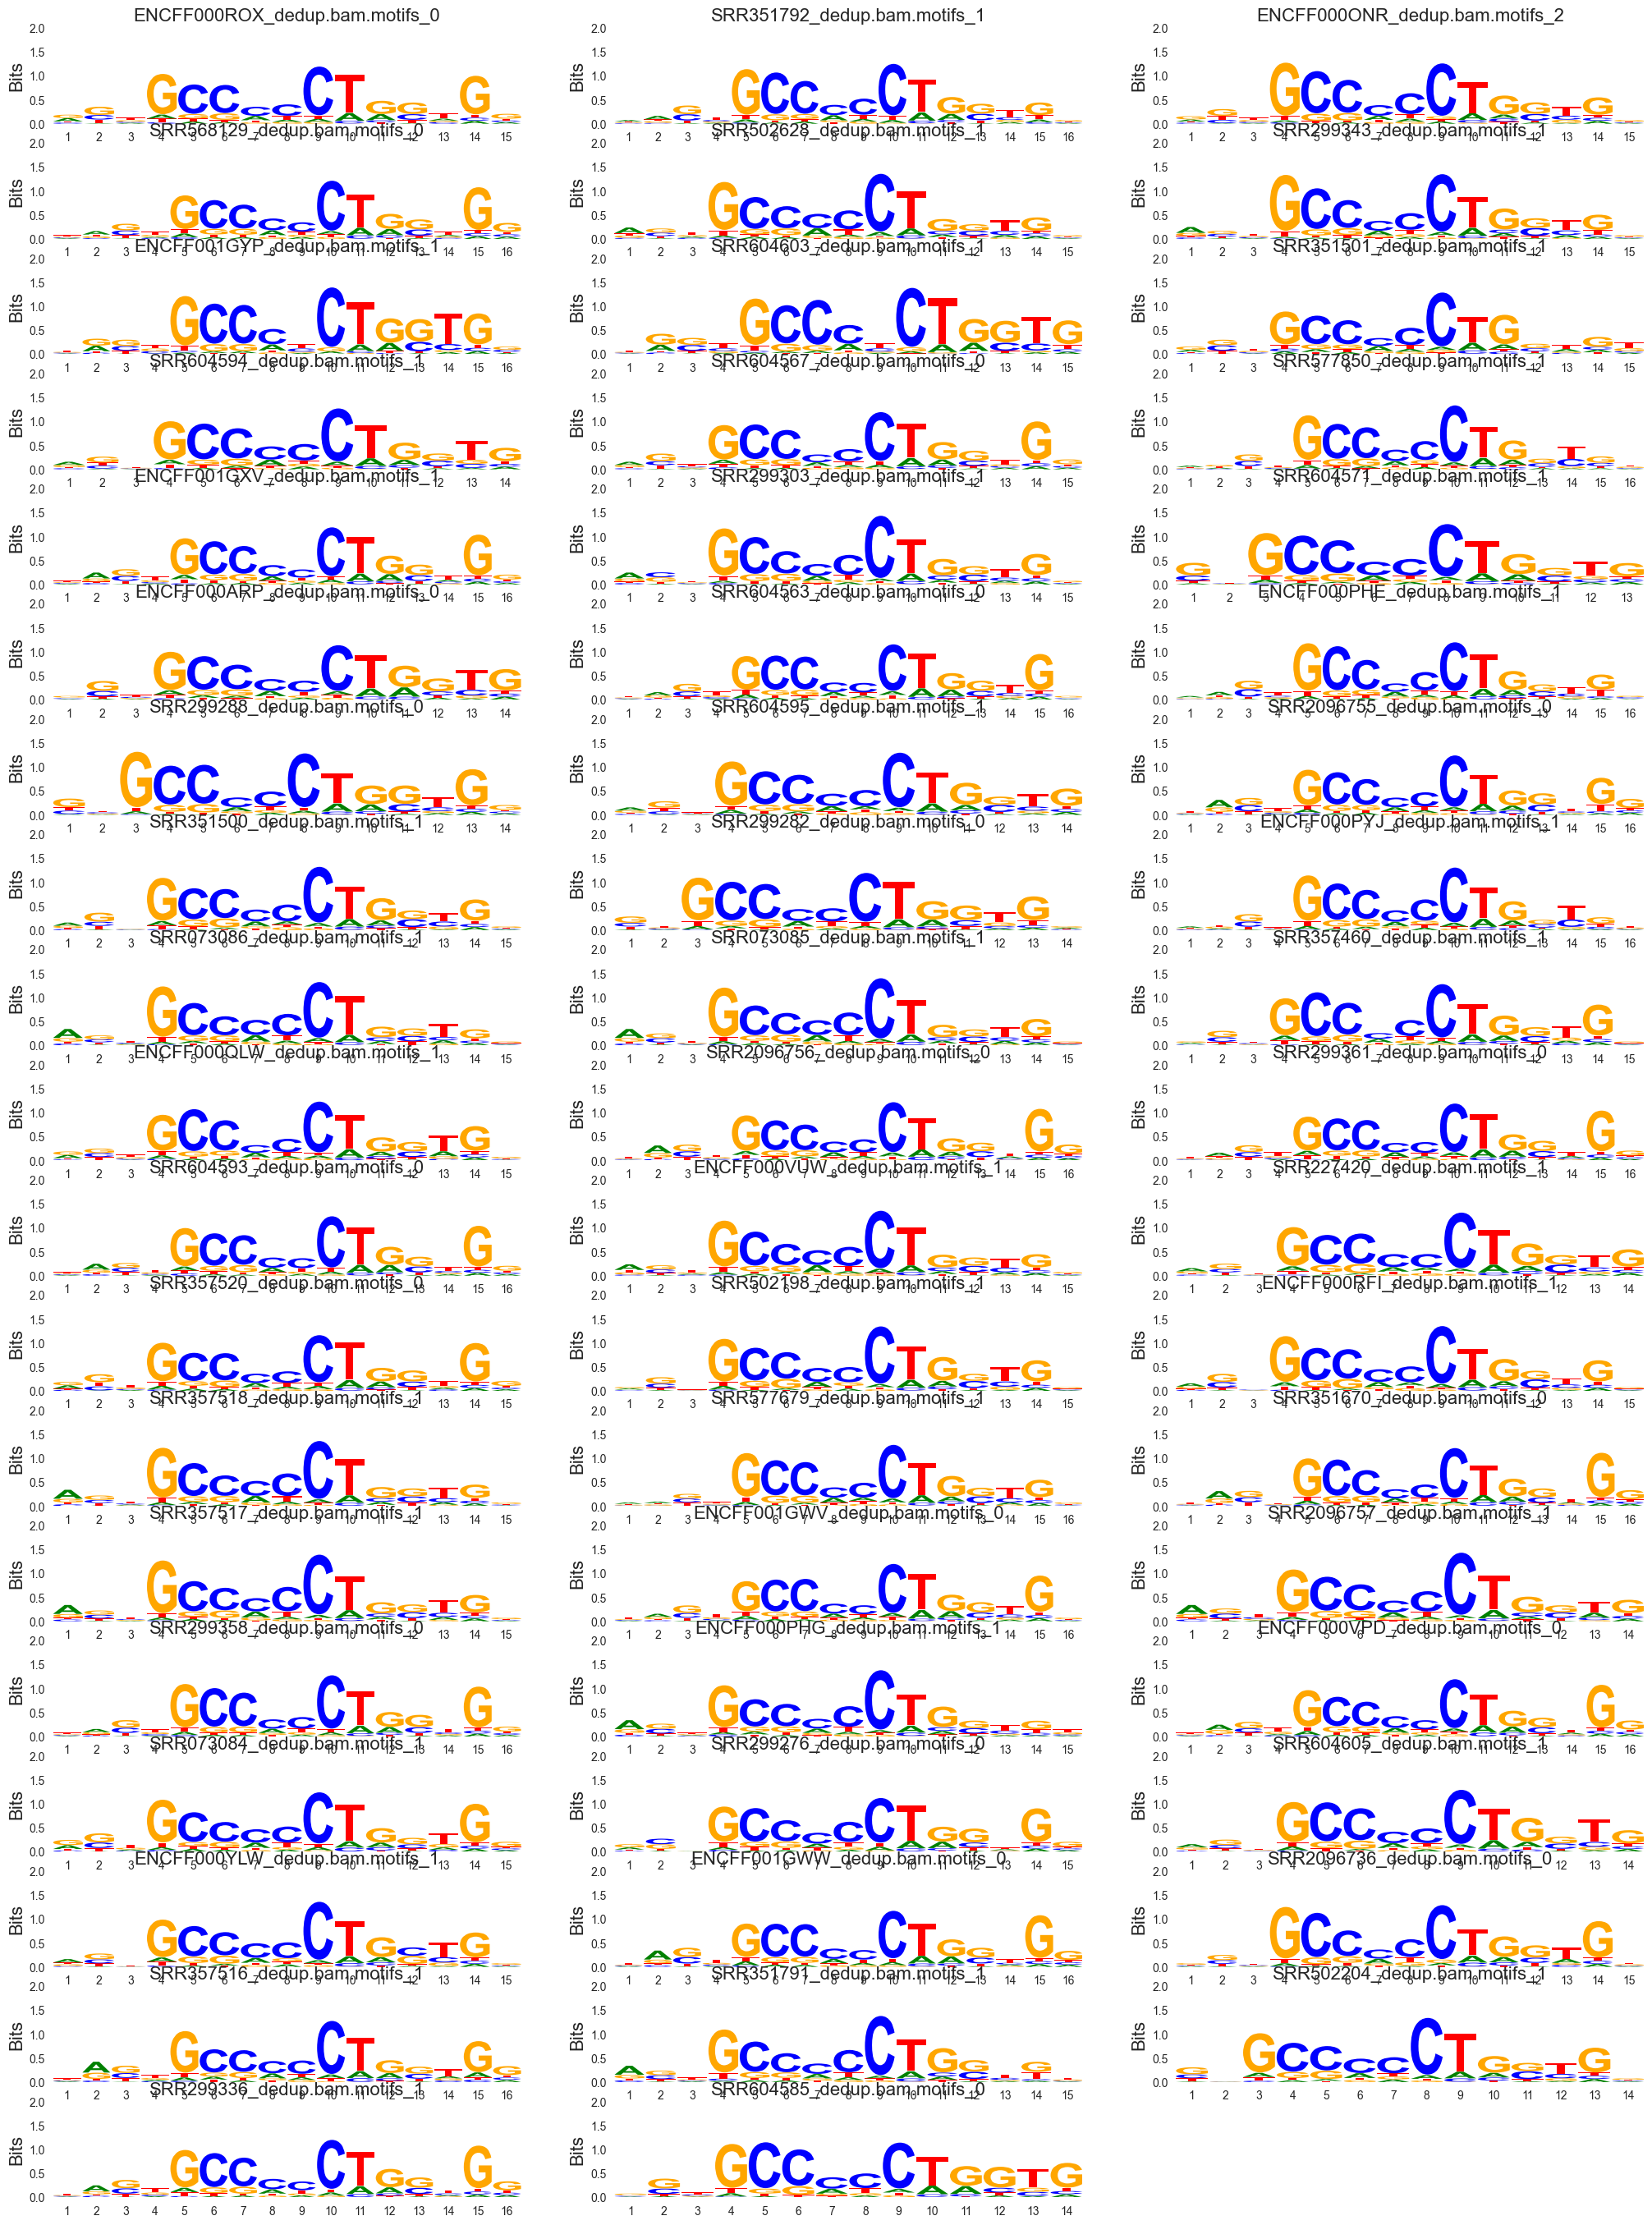

In [ ]:
plt.figure(figsize=(25,35), dpi=100)

for i, motif in enumerate(cl_1):
    ax = plt.subplot(math.ceil(len(cl_1)/3.), 3, i+1)
    motif.trim(0.5).plot_logo(ax=ax)

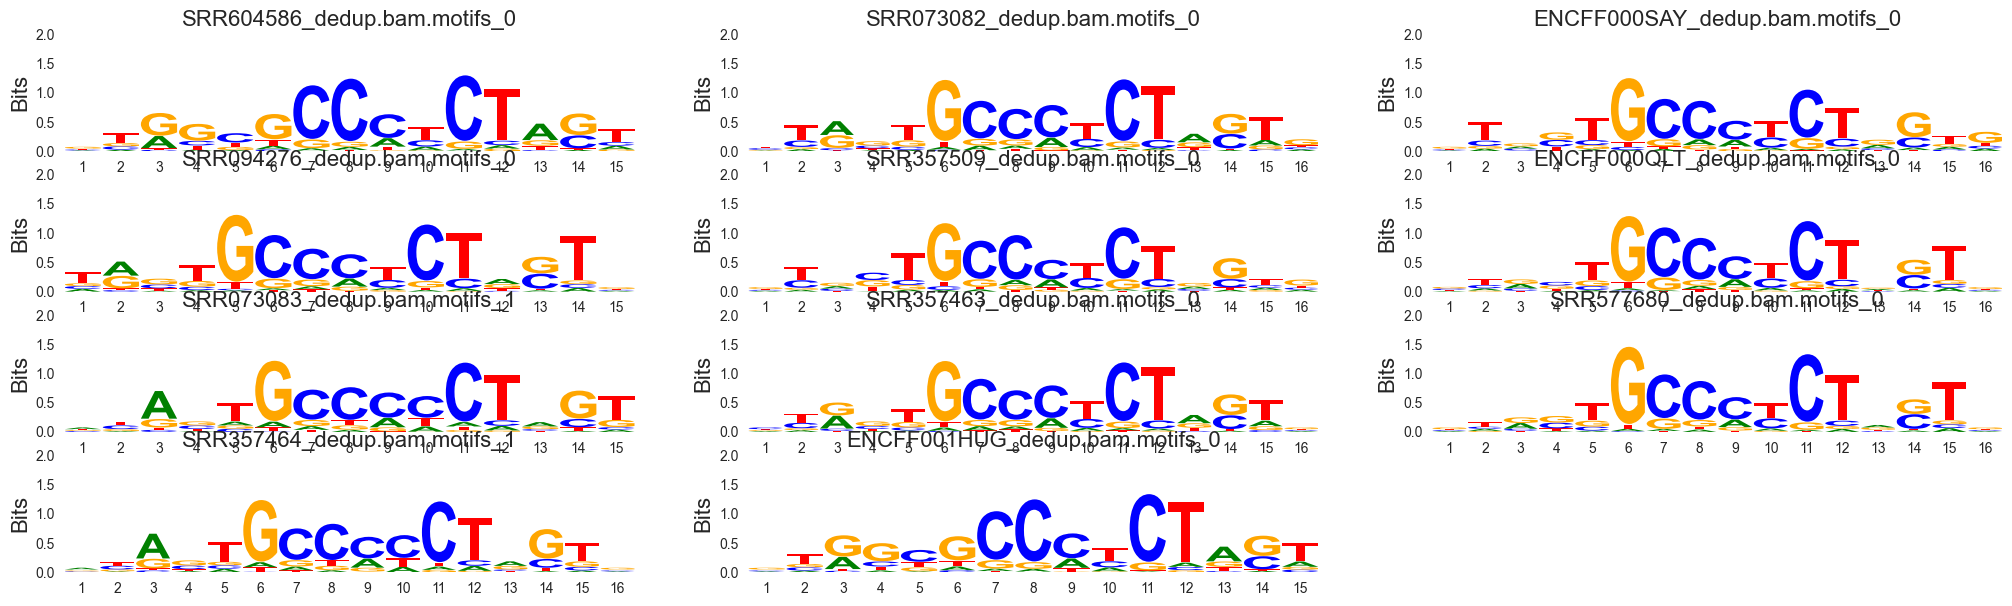

In [ ]:
plt.figure(figsize=(25,35), dpi=100)

for i, motif in enumerate(cl_2):
    ax = plt.subplot(math.ceil(len(cl_1)/3.), 3, i+1)
    motif.trim().plot_logo(ax=ax)

## Try to average each cluster

In [ ]:
alignment_motif = cl_2[random.randint(0,len(cl_2)-1)].trim(0.6)
list(zip(cl_2, [mc.compare_motifs(alignment_motif, motif.trim(), match='partial') for motif in cl_2]))

[(SRR604586_dedup.bam.motifs_0_GTrGCGCCCTCTAsT, [0.7557989143877938, 0, 1]),
 (SRR073082_dedup.bam.motifs_0_yTrnTGCCCyCTrsTG, [-0.7716222822276588, 0, 1]),
 (ENCFF000SAY_dedup.bam.motifs_0_GTnsTGCCCyCTrGTG,
  [-0.7685426846740794, 0, 1]),
 (SRR094276_dedup.bam.motifs_0_TrsTGCCCyCTnsTG, [-0.9459137646533757, 1, 1]),
 (SRR357509_dedup.bam.motifs_0_GynsTGCCCyCTnGTG, [-0.8122019529508367, 0, 1]),
 (ENCFF000QLT_dedup.bam.motifs_0_syrnTGCCCyCTnsTG,
  [-0.9118014585683843, 0, 1]),
 (SRR073083_dedup.bam.motifs_1_AyAnTGCCCCCTnGT, [-1.7062447843445356, 0, 1]),
 (SRR357463_dedup.bam.motifs_0_CyrnTGCCCyCTrsTG, [-0.8900230164348248, 0, 1]),
 (SRR577680_dedup.bam.motifs_0_GTrsTGCCCyCTnsTG, [-0.45816454807877083, 0, 1]),
 (SRR357464_dedup.bam.motifs_1_AyAsTGCCCCCTrGTG, [-1.7491803371947874, 0, 1]),
 (ENCFF001HUG_dedup.bam.motifs_0_GTrGCGCCCTCTAsT, [1.0199360280340242, 0, 1])]

In [ ]:
def average_cluster(cluster):
    # pick a random motif to align on
    alignment_motif = cluster[random.randint(0,len(cluster)-1)]
    alignments = list(map(lambda tuple: [tuple[0], *tuple[1]], zip(cluster, [mc.compare_motifs(alignment_motif, motif, match='partial') for motif in cluster])))
    # print(list(alignments))
    min_shift = abs(min(*map(lambda row: row[3], alignments), 0))

    sum_l = []
    for motif, _, shift, strand in alignments:
        if strand < 0:
            motif = motif.rc()
        
        # print(motif)
        sum_l.append( (motif >> (min_shift + shift)) * motif.kmer_count)

    return sum(sum_l)



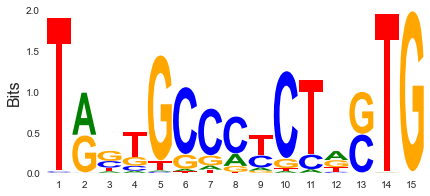

In [ ]:
test = list(map(Motif.trim, cl_2))
average_cluster(test).trim().plot_logo()

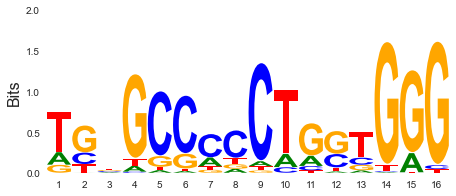

In [ ]:
test = list(map(Motif.trim, cl_1))
average_cluster(test).trim().plot_logo()

In [ ]:
test = list(map(Motif.trim, high_kmer_motifs))
full_average_motif = average_cluster(test).trim()
full_average_motif.plot_logo()

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

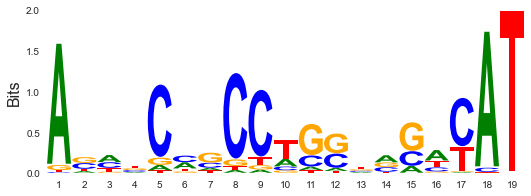

In [ ]:
deepcopy(full_average_motif).trim(0.8).plot_logo()

In [ ]:
mc.get_closest_match([deepcopy(full_average_motif).trim(0.8)], dbmotifs=read_motifs("HOMER"), metric="seqcor", parallel=False)

{'': ['GNCACGTG_BMAL1(bHLH)/Liver-Bmal1-ChIP-Seq(GSE39860)/Homer',
  [0.4353817672483946, 12, 1, nan]]}

## Picking motifs that are concordant with binding variants

In [ ]:
asb_data = dd.read_csv("asb/*.csv", include_path_column=True)
asb_data.head()

,ID,CHROM,POS,REF,ALT,REF.counts,ALT.counts,Total.counts,AR,RMbias,RAF,Bayes_lower,Bayes_upper,Bayes_SD,Corrected.AR,isASB,peak,path
0,rs1043897,chr1,230416399,G,T,6,2,8,0.750000,0.498905,0.670985,0.266662,0.814342,0.143168,0.540502,False,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...
1,rs10494924,chr1,209527706,T,G,38,43,81,0.469136,0.507349,0.413892,0.452832,0.655640,0.052384,0.554236,False,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...
2,rs1061511,chr1,160189500,C,A,80,62,142,0.563380,0.536405,0.599027,0.387567,0.544682,0.040788,0.466124,False,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...
3,rs10800374,chr1,168606715,G,A,9,32,41,0.219512,0.514544,0.347637,0.220050,0.527530,0.079390,0.373790,False,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...
4,rs10911467,chr1,183885406,A,G,65,30,95,0.684211,0.496446,0.668285,0.422900,0.632446,0.053866,0.527673,False,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...


In [ ]:
asb_sites = asb_data[asb_data.isASB].compute()

In [ ]:
asb_sites

,ID,CHROM,POS,REF,ALT,REF.counts,ALT.counts,Total.counts,AR,RMbias,RAF,Bayes_lower,Bayes_upper,Bayes_SD,Corrected.AR,isASB,peak,path
9,rs12029054,chr1,249121038,A,C,4,43,47,0.085106,0.487625,0.384988,0.071294,0.296318,0.058421,0.183806,True,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...
16,rs16841877,chr1,241774286,C,T,67,10,77,0.870130,0.515703,0.675301,0.619430,0.851758,0.059769,0.735594,True,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...
20,rs2000319,chr1,223885843,G,A,5,39,44,0.113636,0.514544,0.355200,0.107990,0.376687,0.070509,0.242339,True,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...
22,rs2242194,chr1,154990297,C,G,229,130,359,0.637883,0.479728,0.355978,0.714388,0.800535,0.021400,0.757461,True,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...
49,rs6664001,chr1,207578284,C,T,37,5,42,0.880952,0.515703,0.653474,0.600617,0.892806,0.075285,0.746711,True,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63623,rs960479,chr21,16060592,C,A,21,2,23,0.913043,0.523603,0.597749,0.668756,0.961727,0.078652,0.815242,True,False,/Users/oalmelid/src/prototypes/motifs/asb/T-47...
63629,rs9636883,chr21,35941558,T,C,2,15,17,0.117647,0.495398,0.491456,0.049551,0.359007,0.084409,0.204279,True,False,/Users/oalmelid/src/prototypes/motifs/asb/T-47...
63708,rs9983351,chr21,39176328,G,A,12,5,17,0.705882,0.523783,0.354810,0.631188,0.931858,0.078947,0.781523,True,False,/Users/oalmelid/src/prototypes/motifs/asb/T-47...
63709,rs9983504,chr21,35246780,A,T,3,10,13,0.230769,0.487593,0.609259,0.065545,0.389901,0.088467,0.227723,True,False,/Users/oalmelid/src/prototypes/motifs/asb/T-47...


In [ ]:
asb_sites.peak.value_counts()

False    10487
True      2615
Name: peak, dtype: int64

In [ ]:
genome = ReferenceGenome("genome/hg19.fa.bz2")

In [ ]:
def get_sequences(row, genome=genome):
    sequence = genome.get_peak(row.CHROM, row.POS)
    assert sequence[genome.offset] == row.REF
    ref_seq = sequence
    alt_seq = sequence[:genome.offset] + row.ALT + sequence[:genome.offset+1]
    return pd.Series({"ref_seq" : ref_seq, "alt_seq": alt_seq})

In [ ]:
asb_peak_sites = asb_sites[asb_sites.peak].reset_index(drop=True)
asb_peak_sites = asb_peak_sites.join(asb_peak_sites.apply(get_sequences, axis=1))
asb_peak_sites.head()

,ID,CHROM,POS,REF,ALT,REF.counts,ALT.counts,Total.counts,AR,RMbias,RAF,Bayes_lower,Bayes_upper,Bayes_SD,Corrected.AR,isASB,peak,path,ref_seq,alt_seq
0,rs12029054,chr1,249121038,A,C,4,43,47,0.085106,0.487625,0.384988,0.071294,0.296318,0.058421,0.183806,True,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...,AAGGGGAAGGGCTTCATTCAGGGTTGGATGTTTTGTTTTTACAAAA...,AAGGGGAAGGGCTTCATTCAGGGTTGGATGTTTTGTTTTTACAAAA...
1,rs16841877,chr1,241774286,C,T,67,10,77,0.870130,0.515703,0.675301,0.619430,0.851758,0.059769,0.735594,True,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...,TCACCAGTAAAACTGAGATAATAGTACCAAAATGCTGTCTCATCGT...,TCACCAGTAAAACTGAGATAATAGTACCAAAATGCTGTCTCATCGT...
2,rs2000319,chr1,223885843,G,A,5,39,44,0.113636,0.514544,0.355200,0.107990,0.376687,0.070509,0.242339,True,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...,CTATGTCCTCTGTAAGGACAGTACAGTATCCTGTTCACGGTTGAAG...,CTATGTCCTCTGTAAGGACAGTACAGTATCCTGTTCACGGTTGAAG...
3,rs2242194,chr1,154990297,C,G,229,130,359,0.637883,0.479728,0.355978,0.714388,0.800535,0.021400,0.757461,True,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...,TCTTCACGCTCCTCATCCACCCCAGCTGGTGAGCGGCGCCCCCTTG...,TCTTCACGCTCCTCATCCACCCCAGCTGGTGAGCGGCGCCCCCTTG...
4,rs6664001,chr1,207578284,C,T,37,5,42,0.880952,0.515703,0.653474,0.600617,0.892806,0.075285,0.746711,True,True,/Users/oalmelid/src/prototypes/motifs/asb/A549...,TTTTATAACTTACTGTCTTCTGCTACCCAGTTCCAGAGATTTGAGG...,TTTTATAACTTACTGTCTTCTGCTACCCAGTTCCAGAGATTTGAGG...


In [ ]:
scanner = Scanner()
scanner.set_motifs(high_kmer_motifs)
ref_matches = list(scanner.best_match(Fasta(fdict=asb_peak_sites.ref_seq.to_dict())))
alt_matches = list(scanner.best_match(Fasta(fdict=asb_peak_sites.alt_seq.to_dict())))

Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag


In [ ]:
# def normalize_score(score, motif):
#     min_score = motif.linear_min_score()
#     max_score = motif.lienar_max_score()
#     return (score - min_score)/(max_score-min_score)

In [ ]:
def score_diff(set1, set2, motif):
    score1, pos1, strand1 = set1
    score2, pos2, strand2 = set2

    min_score = motif.pwm_min_score()
    max_score = motif.pwm_max_score()

    if strand1 != strand2:
        return 0
    elif pos1 != pos2:
        return 0
    elif max_score == min_score:
        return 0
    else:
        result = (score1-score2)/(max_score-min_score)
        # print(result, max_score, min_score, score1, score2)
        return result

In [ ]:
scores = []
for sequence in zip(ref_matches, alt_matches):
    inner = []
    for ref_set, alt_set, motif in zip(*sequence, high_kmer_motifs):
         inner.append(score_diff(ref_set, alt_set, motif))
    scores.append(inner)

In [ ]:
max(max(row) for row in scores)

0.24817671328969515

In [ ]:
asb_peak_sites["Corrected.AR"]

0       0.183806
1       0.735594
2       0.242339
3       0.757461
4       0.746711
          ...   
2610    0.679673
2611    0.685122
2612    0.738834
2613    0.301621
2614    0.778731
Name: Corrected.AR, Length: 2615, dtype: float64

In [ ]:
coords = sum(map(lambda row: [(row[1], entry) for entry in row[0] if entry != 0], zip(scores, list(asb_peak_sites["Corrected.AR"]))), [])

In [ ]:
pd.DataFrame(coords)

<AxesSubplot:>

ValueError: Image size of 375x67308 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 432x288 with 1 Axes>

In [ ]:
list(zip([1,2,3], [4,5,6]))

[(1, 4), (2, 5), (3, 6)]

# GimmeMotif's built-in clustering algorithm

In [7]:
high_ic_cluster = cluster_motifs(high_ic_motifs, trim_edges=True)

Calculating initial scores
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Clustering [          ] 1%Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fon

In [22]:
help(cluster_motifs)

Help on function cluster_motifs in module gimmemotifs.cluster:

cluster_motifs(motifs, match='total', metric='wic', combine='mean', pval=True, threshold=0.95, trim_edges=False, edge_ic_cutoff=0.2, include_bg=True, progress=True, ncpus=None)
    Clusters a set of sequence motifs. Required arg 'motifs' is a file containing
    positional frequency matrices or an array with motifs.
    
    Optional args:
    
    'match', 'metric' and 'combine' specify the method used to compare and score
    the motifs. By default the WIC score is used (metric='wic'), using the the
    score over the whole alignment (match='total'), with the total motif score
    calculated as the mean score of all positions (combine='mean').
    'match' can be either 'total' for the total alignment or 'subtotal' for the
    maximum scoring subsequence of the alignment.
    'metric' can be any metric defined in MotifComparer, currently: 'pcc', 'ed',
    'distance', 'wic' or 'chisq'
    'combine' determines how the total

In [65]:
high_kmer_cluster = cluster_motifs(high_kmer_motifs, trim_edges=True, ncpus=4, metric="seqcor", threshold=0.6, pval=False)

Calculating initial scores
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Clustering [          ] 2%Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Fontconfig warning: ignoring UTF-8: not a valid region tag
Clu

In [9]:
len(high_ic_cluster.get_clustered_motifs())

40

In [34]:
score_mat = [[ mc.compare_motifs(m1, m2, metric="seqcor")[0] for m1 in high_ic_motifs] for m2 in high_ic_motifs]

<AxesSubplot:ylabel='Count'>

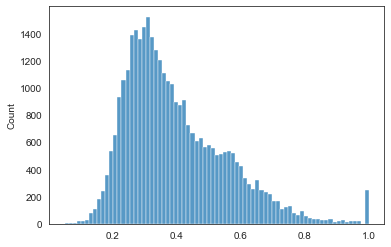

In [39]:
sns.histplot([num for row in score_mat for num in row])

In [31]:
help(mc.compare_motifs)

Help on method compare_motifs in module gimmemotifs.comparison:

compare_motifs(m1, m2, match='total', metric='wic', combine='mean', pval=False) method of gimmemotifs.comparison.MotifComparer instance
    Compare two motifs.
    
    The similarity metric can be any of seqcor, pcc, ed, distance, wic,
    chisq, akl or ssd. If match is 'total' the similarity score is
    calculated for the whole match, including positions that are not
    present in both motifs. If match is partial or subtotal, only the
    matching psotiions are used to calculate the score. The score of
    individual position is combined using either the mean or the sum.
    
    Note that the match and combine parameters have no effect on the seqcor
    similarity metric.
    
    Parameters
    ----------
    m1 : Motif instance
        Motif instance 1.
    
    m2 : Motif instance
        Motif instance 2.
    
    match : str, optional
        Match can be "partial", "subtotal" or "total". Not all metrics use
   

In [66]:
motif_cluster = high_kmer_cluster.get_clustered_motifs()
print(len(motif_cluster))

13


in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...
in validate_matrix(): Row sums in df are not close to 1. Reormal

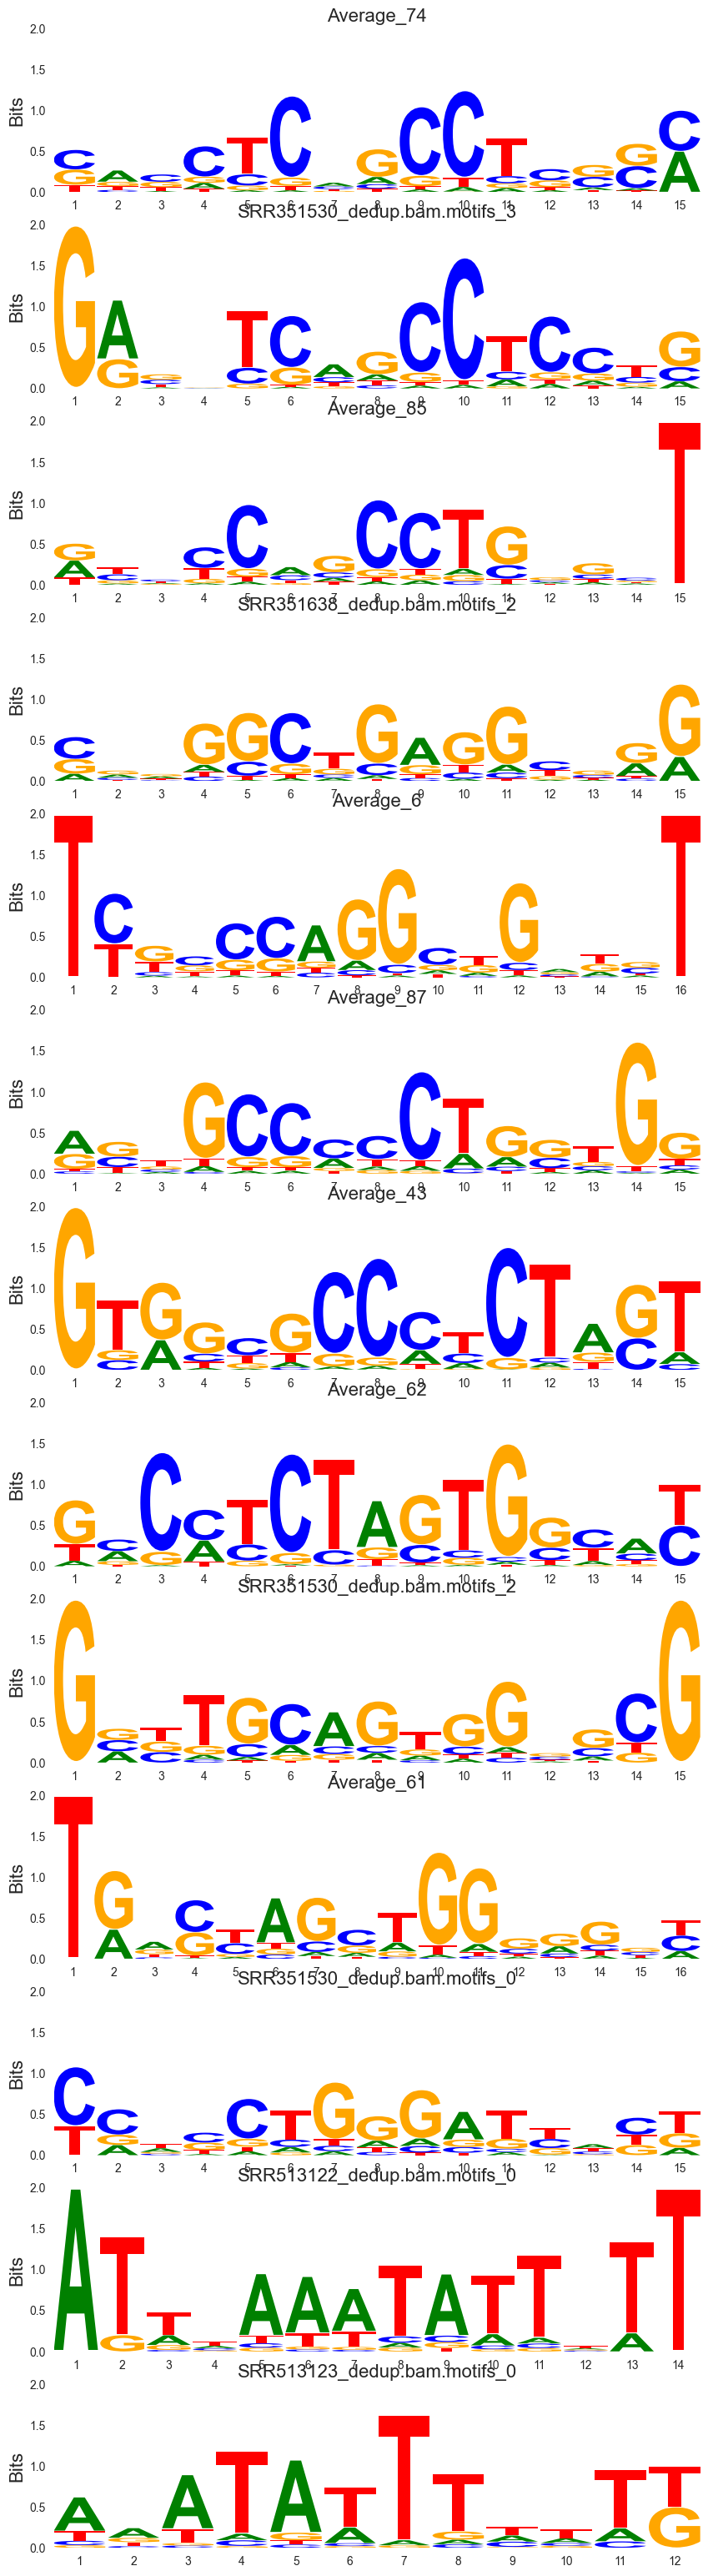

In [67]:
plt.figure(figsize =(10,40), dpi=100)

for i, motif in enumerate(motif_cluster):
    ax = plt.subplot(len(motif_cluster), 1, i+1)
    motif.trim().plot_logo(ax=ax)

In [68]:
mc = MotifComparer()
best_matching_motifs = mc.get_closest_match(motif_cluster, dbmotifs=read_motifs("HOMER"), metric="seqcor", parallel=False)
print(best_matching_motifs)

{'Average_74': ['TTGCCAAG_NF1-halfsite(CTF)/LNCaP-NF1-ChIP-Seq(Unpublished)/Homer', [0.46121234437195, 8, -1, nan]], 'SRR351530_dedup.bam.motifs_3': ['TGGTACATTCCA_PRDM10(Zf)/HEK293-PRDM10.eGFP-ChIP-Seq(Encode)/Homer', [0.5438789975873212, -1, 1, nan]], 'Average_85': ['YCCDNTCCAGGTTTT_PRDM15(Zf)/ESC-Prdm15-ChIP-Seq(GSE73694)/Homer', [0.5329421250704712, 1, 1, nan]], 'SRR351638_dedup.bam.motifs_2': ['SMCAGTCWGAKGGAGGAGGC_ZSCAN22(Zf)/HEK293-ZSCAN22.GFP-ChIP-Seq(GSE58341)/Homer', [0.49082647621394604, -1, 1, nan]], 'Average_6': ['TTCGCGCGAAAA_E2F(E2F)/Hela-CellCycle-Expression/Homer', [0.4915585278806054, -1, -1, nan]], 'Average_87': ['CNNBRGCGCCCCCTGSTGGC_BORIS(Zf)/K562-CTCFL-ChIP-Seq(GSE32465)/Homer', [0.8414569903832548, -4, 1, nan]], 'Average_43': ['CNNBRGCGCCCCCTGSTGGC_BORIS(Zf)/K562-CTCFL-ChIP-Seq(GSE32465)/Homer', [0.631827346187809, -2, 1, nan]], 'Average_62': ['CNNBRGCGCCCCCTGSTGGC_BORIS(Zf)/K562-CTCFL-ChIP-Seq(GSE32465)/Homer', [0.6969818740238986, -7, 1, nan]], 'SRR351530_dedup

In [63]:
print(best_matching_motifs)

{'Average_74': ['TTGCCAAG_NF1-halfsite(CTF)/LNCaP-NF1-ChIP-Seq(Unpublished)/Homer', [0.46121234437195, 8, -1, nan]], 'SRR351530_dedup.bam.motifs_3': ['TGGTACATTCCA_PRDM10(Zf)/HEK293-PRDM10.eGFP-ChIP-Seq(Encode)/Homer', [0.5438789975873212, -1, 1, nan]], 'SRR357459_dedup.bam.motifs_2': ['RHHCAGAGAGGB_ZNF768(Zf)/Rajj-ZNF768-ChIP-Seq(GSE111879)/Homer', [0.5082629681081096, 7, -1, nan]], 'SRR357486_dedup.bam.motifs_1': ['YCCDNTCCAGGTTTT_PRDM15(Zf)/ESC-Prdm15-ChIP-Seq(GSE73694)/Homer', [0.5204998876754712, 2, 1, nan]], 'Average_57': ['YCCDNTCCAGGTTTT_PRDM15(Zf)/ESC-Prdm15-ChIP-Seq(GSE73694)/Homer', [0.4900771581115869, 2, 1, nan]], 'SRR351638_dedup.bam.motifs_2': ['SMCAGTCWGAKGGAGGAGGC_ZSCAN22(Zf)/HEK293-ZSCAN22.GFP-ChIP-Seq(GSE58341)/Homer', [0.49082647621394604, -1, 1, nan]], 'Average_6': ['TTCGCGCGAAAA_E2F(E2F)/Hela-CellCycle-Expression/Homer', [0.4915585278806054, -1, -1, nan]], 'Average_78': ['CNNBRGCGCCCCCTGSTGGC_BORIS(Zf)/K562-CTCFL-ChIP-Seq(GSE32465)/Homer', [0.7050623444426924, -2,

In [64]:
[get_tf_from_name(motif) for motif in best_matching_motifs.values()]

['NF1',
 'PRDM10.eGFP',
 'ZNF768',
 'Prdm15',
 'Prdm15',
 'ZSCAN22.GFP',
 'CellCycle',
 'CTCFL',
 'CTCF',
 'CTCFL',
 'CTCFL',
 'CTCFL',
 'CTCFL',
 'CTCF',
 'CTCF',
 'CTCFL',
 'CTCFL',
 'Prep1',
 'BCL11A',
 'EBF',
 'Pit1',
 'Hoxa13.Flag']

In [22]:
help(read_motifs)

Help on function read_motifs in module gimmemotifs.motif:

read_motifs(infile=None, fmt='pfm', as_dict=False)
    Read motifs from a file or stream or file-like object.
    
    Parameters
    ----------
    infile : string or file-like object, optional
        Motif database, filename of motif file or file-like object. If infile
        is not specified the default motifs as specified in the config file
        will be returned.
    
    fmt : string, optional
        Motif format, can be 'pfm', 'transfac', 'xxmotif', 'jaspar' or 'align'.
    
    as_dict : boolean, optional
        Return motifs as a dictionary with motif_id, motif pairs.
    
    Returns
    -------
    motifs : list
        List of Motif instances. If as_dict is set to True, motifs is a
        dictionary.

